In [26]:
import ydata_profiling

SEED = 2022
#!/usr/bin/env python
import sys
import os
sys.path.append('src/')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import argparse
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.decomposition import PCA
import logging
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import (
    TimeSeriesSplit,
    cross_val_score,
    cross_validate,
    train_test_split,
)
import time
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
from xgboost import XGBRegressor

ModuleNotFoundError: No module named 'sklearn.pipeline'

# Load the data

In [3]:
train_df = pd.read_csv('Data/housing_price/train.csv', index_col=0)

In [4]:
train_df.reset_index(inplace=True, drop=True)

In [5]:
train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [7]:
drop_features = ['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']

In [15]:
train_df.drop(columns=drop_features, inplace=True)

In [16]:
missing_features = train_df.columns[train_df.isnull().any()].to_list()
missing_features

['LotFrontage',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond']

In [17]:
missing_df = train_df[missing_features]
missing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LotFrontage   1201 non-null   float64
 1   MasVnrType    1452 non-null   object 
 2   MasVnrArea    1452 non-null   float64
 3   BsmtQual      1423 non-null   object 
 4   BsmtCond      1423 non-null   object 
 5   BsmtExposure  1422 non-null   object 
 6   BsmtFinType1  1423 non-null   object 
 7   BsmtFinType2  1422 non-null   object 
 8   Electrical    1459 non-null   object 
 9   GarageType    1379 non-null   object 
 10  GarageYrBlt   1379 non-null   float64
 11  GarageFinish  1379 non-null   object 
 12  GarageQual    1379 non-null   object 
 13  GarageCond    1379 non-null   object 
dtypes: float64(3), object(11)
memory usage: 159.8+ KB


In [19]:
missing_df.tail()

,LotFrontage,MasVnrType,MasVnrArea,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Electrical,GarageType,GarageYrBlt,GarageFinish,GarageQual,GarageCond
1455,62.0,None,0.0,Gd,TA,No,Unf,Unf,SBrkr,Attchd,1999.0,RFn,TA,TA
1456,85.0,Stone,119.0,Gd,TA,No,ALQ,Rec,SBrkr,Attchd,1978.0,Unf,TA,TA
1457,66.0,None,0.0,TA,Gd,No,GLQ,Unf,SBrkr,Attchd,1941.0,RFn,TA,TA
1458,68.0,None,0.0,TA,TA,Mn,GLQ,Rec,FuseA,Attchd,1950.0,Unf,TA,TA
1459,75.0,None,0.0,TA,TA,No,BLQ,LwQ,SBrkr,Attchd,1965.0,Fin,TA,TA


In [24]:
missing_df['LotFrontage'].describe()

count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

In [25]:
missing_df['MasVnrType'].value_counts()

None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

In [ ]:


logger = logging.getLogger('Syndromics Surveillance')

def fit_processor(X_train, numeric_features, categorical_features, output_dir):
    """
    Applies Simple Imputer to Categorical Features
    Applies One Hot Encoding to Categorical Features
    Applies Quantile Scaling to Numeric Features
    Returns and writes pickle file of the complete preprocessor

    Parameters
    ----------
    X_train : numpy
        Training Data in NumPy format
    numeric_features : list[string]
        List of Numeric Features
    categorical_features: list[string]
        List of Categorical Features
    output_dir: string
        Output directory to write the preprocessor to

    Returns
    -------
    preprocessor : sklearn.Preprocessor
        sklearn preprocessor fit on the training set
    """
    pipe_num = Pipeline([
        ('impute', SimpleImputer(strategy='constant', fill_value=0)),
        ('scaler',  MinMaxScaler())
    ])
    pipe_cat = Pipeline([
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False)),
        ('impute', SimpleImputer(strategy='constant', fill_value=0))

    ]) 
    preprocessor = ColumnTransformer([
        ('num', pipe_num, numeric_features),
        ('cat', pipe_cat, categorical_features)
    ])
    logger.info("Preprocessing X_train")
    norm_X_train = preprocessor.fit(X_train)
    with open(os.path.join(output_dir, 'processor.pkl'),'wb') as f:
        pickle.dump(preprocessor, f)
    return preprocessor

In [18]:
train_df.shape

(1460, 75)

In [11]:
features = ['LotArea', 'YearBuilt', 'Fireplaces', 'PoolArea', 'OverallQual', 'TotalBsmtSF', 'MiscVal', 'OverallCond', 'GarageArea', 'GarageCars']

In [12]:
train_df[features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   LotArea      1460 non-null   int64
 1   YearBuilt    1460 non-null   int64
 2   Fireplaces   1460 non-null   int64
 3   PoolArea     1460 non-null   int64
 4   OverallQual  1460 non-null   int64
 5   TotalBsmtSF  1460 non-null   int64
 6   MiscVal      1460 non-null   int64
 7   OverallCond  1460 non-null   int64
 8   GarageArea   1460 non-null   int64
 9   GarageCars   1460 non-null   int64
dtypes: int64(10)
memory usage: 114.2 KB


# CHKN NOTES
- train validation and test - 3 fundos
- split it 80 20
- crossvalidation while trainng
- tune hyper paras of model
- but method to it are diff across each thing
- best one to use for tabular is called stratified k fold - time is time- why bother????
- CROSSValidate

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X = train_df[features]
y = train_df[['SalePrice']]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

In [16]:
X_test.shape

(292, 10)

In [17]:
y_train.shape

(1168, 1)

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# Chknnotes2
1. Decide the features
2. Train test split data into X, y
3. Decide the preprocessing
4. Implement crossvalidation
5. test

In [19]:
from sklearn.preprocessing import StandardScaler

In [20]:
scaler = StandardScaler()
norm_X_train = scaler.fit_transform(X_train)
norm_X_test = scaler.transform(X_test)



In [21]:
#this is now an array
norm_X_train

array([[ 5.93446350e-04,  1.20523438e+00, -9.48541784e-01, ...,
        -5.08901445e-01,  1.41435382e+00,  1.64265706e+00],
       [-1.54304453e-01, -1.44916831e-01, -9.48541784e-01, ...,
        -5.08901445e-01,  1.48849490e+00,  1.64265706e+00],
       [-3.30752485e-01,  1.13937334e+00,  6.05310675e-01, ...,
        -5.08901445e-01,  4.69055018e-01,  3.16725169e-01],
       ...,
       [ 1.79570836e-01,  1.04058179e+00,  2.15916313e+00, ...,
        -5.08901445e-01,  1.28924074e+00,  1.64265706e+00],
       [-1.61589005e-01, -2.10777866e-01, -9.48541784e-01, ...,
         2.18474004e+00,  4.87590289e-01,  3.16725169e-01],
       [-6.10499508e-01,  1.07351231e+00,  6.05310675e-01, ...,
        -5.08901445e-01, -2.35285265e-01,  3.16725169e-01]])

In [22]:
from sklearn.model_selection import GridSearchCV

In [23]:
params = {
    'n_estimators':[10,50,100],
    'max_depth':[50,100,200],
    'min_samples_split':[2,3,4]    
}

In [24]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
skf = KFold(n_splits=10, random_state=69, shuffle=True)

In [25]:
clf = GridSearchCV(RandomForestRegressor(), params, cv=skf)

In [26]:
clf.fit(norm_X_train, y_train.values.ravel())

GridSearchCV(cv=KFold(n_splits=10, random_state=69, shuffle=True),
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': [50, 100, 200],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [10, 50, 100]})

In [27]:
clf.best_params_

{'max_depth': 50, 'min_samples_split': 3, 'n_estimators': 50}

In [28]:
clf.score(norm_X_train, y_train)

0.9674101864344103

In [29]:
clf.score(norm_X_test, y_test)

0.8179454373566588

In [31]:
test_df = pd.read_csv('Data/housing_price/test.csv', index_col=0)

In [32]:
test_df.reset_index(inplace=True, drop=True)

In [33]:
test_df.tail()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1454,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal
1458,60,RL,74.0,9627,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,11,2006,WD,Normal


In [34]:
test_df = test_df[features]

In [35]:
test_df

,LotArea,YearBuilt,Fireplaces,PoolArea,OverallQual,TotalBsmtSF,MiscVal,OverallCond,GarageArea,GarageCars
0,11622,1961,0,0,5,882.0,0,6,730.0,1.0
1,14267,1958,0,0,6,1329.0,12500,6,312.0,1.0
2,13830,1997,1,0,5,928.0,0,5,482.0,2.0
3,9978,1998,1,0,6,926.0,0,6,470.0,2.0
4,5005,1992,0,0,8,1280.0,0,5,506.0,2.0
...,...,...,...,...,...,...,...,...,...,...
1454,1936,1970,0,0,4,546.0,0,7,0.0,0.0
1455,1894,1970,0,0,4,546.0,0,5,286.0,1.0
1456,20000,1960,1,0,5,1224.0,0,7,576.0,2.0
1457,10441,1992,0,0,5,912.0,700,5,0.0,0.0


In [36]:
test_df = test_df.fillna(0)

In [37]:
norm_X_test_final = scaler.transform(test_df)


In [38]:
norm_X_test_final

array([[ 0.1166404 , -0.34249994, -0.94854178, ...,  0.38897905,
         1.20119821, -1.00920672],
       [ 0.38424651, -0.44129149, -0.94854178, ...,  0.38897905,
        -0.73573757, -1.00920672],
       [ 0.34003332,  0.84299869,  0.60531068, ..., -0.50890144,
         0.05201143,  0.31672517],
       ...,
       [ 0.96427894, -0.37543045,  0.60531068, ...,  1.28685954,
         0.48759029,  0.31672517],
       [-0.00284648,  0.6783461 , -0.94854178, ..., -0.50890144,
        -2.18148868, -2.33513862],
       [-0.08520239,  0.71127662,  0.60531068, ..., -0.50890144,
         0.8304928 ,  1.64265706]])

In [39]:
y_predict = clf.predict(norm_X_test_final)

In [40]:
y_final = pd.DataFrame(y_predict, columns=['SalePrice'])

In [41]:
final_df = pd.concat([test_df, y_final], axis=1)

In [42]:
final_df.tail()

,LotArea,YearBuilt,Fireplaces,PoolArea,OverallQual,TotalBsmtSF,MiscVal,OverallCond,GarageArea,GarageCars,SalePrice
1454,1936,1970,0,0,4,546.0,0,7,0.0,0.0,86309.366667
1455,1894,1970,0,0,4,546.0,0,5,286.0,1.0,82405.833333
1456,20000,1960,1,0,5,1224.0,0,7,576.0,2.0,172958.533333
1457,10441,1992,0,0,5,912.0,700,5,0.0,0.0,105247.976952
1458,9627,1993,1,0,7,996.0,0,5,650.0,3.0,243806.970000


In [44]:
import shap
shap.initjs()

In [45]:
explainer = shap.Explainer(clf.best_estimator_)
shap_values = explainer(norm_X_test)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


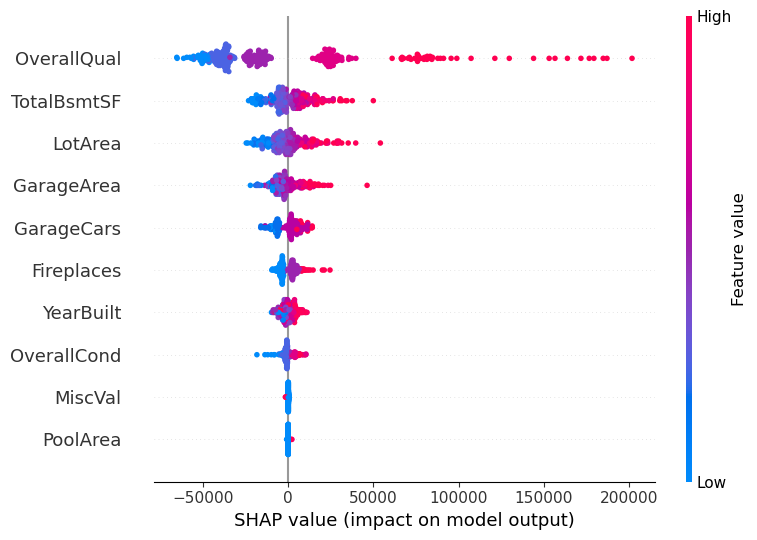

In [46]:
shap.summary_plot(shap_values, norm_X_test, feature_names=features)